# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. 

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    install lifelines

In [1974]:
regulonModules['1655']

['ENSG00000081041',
 'ENSG00000060558',
 'ENSG00000066336',
 'ENSG00000126759',
 'ENSG00000137801',
 'ENSG00000169508']

In [1998]:
for l in range(len(program_list)):
    if '1655' in program_list[l]:
        print(l)

134


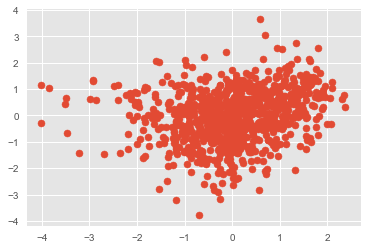

In [1994]:
fgfr3_mut = list(common_mutations.columns[common_mutations.loc['TP53',:]==1])
fgfr3_wt = list(common_mutations.columns[common_mutations.loc['TP53',:]==0])
il6r = 'ENSG00000160712'
sp1 = 'ENSG00000185591'
#plt.boxplot([eigengenes.loc['1568',fgfr3_mut],eigengenes.loc['1568',fgfr3_wt]])
plt.scatter(expressionData.loc[il6r,:],expressionData.loc[sp1,:])

# Begin miner analysis

## Import standard dependencies

In [1927]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner_20190520 as miner
%matplotlib inline
plt.style.use('ggplot')

In [1928]:
# XGBoost predictor imports
os.environ['KMP_DUPLICATE_LIB_OK']='True' #prevents kernel from dying when running XGBClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree

## Create directory to save output files

In [1929]:
# create name for results folder where output files will be saved
resultsFolder = "results_minCorrelation_0o2_50"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load previous results (skip if results have not previously been generated)

In [4]:
# #If previous results exist, use miner.read_json to load them
# revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))
# coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
# regulonModules = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
# mechanisticOutput = miner.read_json(os.path.join(resultsDirectory,"mechanisticOutput.json"))
# regulonDf = pd.read_csv(os.path.join(resultsDirectory,"regulonDf.csv"),index_col=0,header=0)
# overExpressedMembersMatrix = pd.read_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"),index_col=0,header=0)
# underExpressedMembersMatrix = pd.read_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"),index_col=0,header=0)
# coherent_samples_matrix = pd.read_csv(os.path.join(resultsDirectory,"coherentMembers.csv"),index_col=0,header=0)

## Load reference dictionary for mechanistic inference (skip if using default)

In [ ]:
# #provide absolute path to your .csv-format reference database
# filename = os.path.join(os.path.split(os.getcwd())[0],"data","reference_database_example.csv")
# #provide absolute path to the miner/data/network_dictionaries directory where your database will be stored
# network_dictionaries_path = os.path.join(os.path.split(os.getcwd())[0],"data","network_dictionaries")
# #name your reference database and use the extension ".pkl"
# dictionaryName = "reference_database.pkl"
# #import and save your reference database to the Python pickle format for future use
# reference_mechanistic_database = miner.fileToReferenceDictionary(filename,os.path.join(network_dictionaries_path,dictionaryName))

# 0. Load and pre-process data; set parameters

In [1930]:
# Load expression Data
expressionFile = os.path.join(os.path.split(os.getcwd())[0],"data","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

completed identifier conversion.
16216 genes were converted.


Text(0.5,0,u'Relative expression')

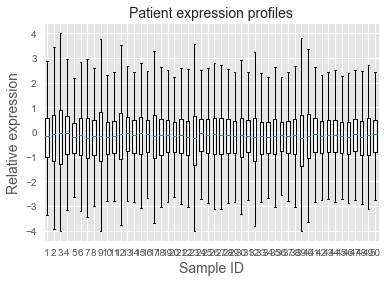

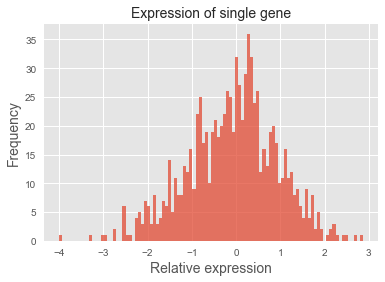

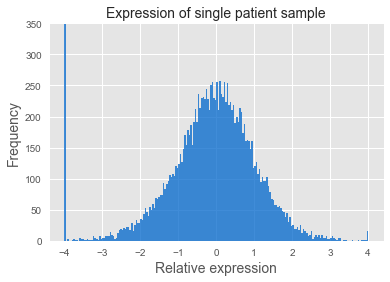

In [1931]:
individual_expression_data = [expressionData.iloc[:,i] for i in range(50)]
_ = plt.boxplot(individual_expression_data)
plt.title("Patient expression profiles",FontSize=14)
plt.ylabel("Relative expression",FontSize=14)
plt.xlabel("Sample ID",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[0,:],bins=100,alpha=0.75)
plt.title("Expression of single gene",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[:,0],bins=200,color=[0,0.4,0.8],alpha=0.75)
plt.ylim(0,350)
plt.title("Expression of single patient sample",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)

## Set parameters

In [1932]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = "tfbsdb_tf_to_genes.pkl" #default option
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# number of cores available for multiprocessing
numCores = 5

# 1. Co-expression clustering

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 6.19 minutes
Number of genes clustered: 15196
Number of unique clusters: 1233
Completed clustering module in 8.14 minutes


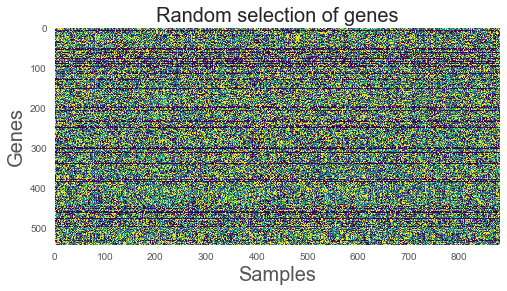

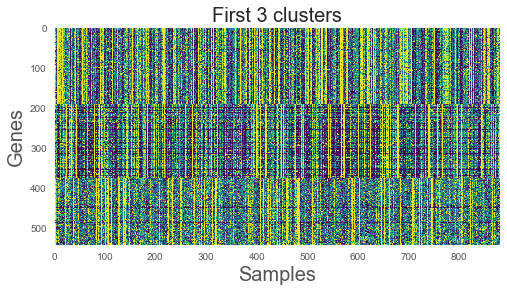

In [1933]:
reload(miner)
t1 = time.time()
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))
# ensure that keys have type str

# retrieve first three clusters for visual inspection
first_clusters = np.hstack([revisedClusters[i] for i in np.arange(3).astype(str)])

# visualize background expression
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[np.random.choice(expressionData.index,len(first_clusters),replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("Random selection of genes",FontSize=20)

# visualize first 10 clusters
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 3 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t2 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t2-t1)/60.))

# 2. Mechanistic inference

In [1934]:
reload(miner)
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,database=mechanistic_database)
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
#write annotated regulon table to .csv
regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(annotatedRegulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(annotatedCoexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))
t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))

Running mechanistic inference
Completed mechanistic inference in 6.30 minutes
Inferred network with 3203 regulons, 392 regulators, and 8549 co-regulated genes


# 3. Causal inference

In [1935]:
# Load mutation matrices
common_mutations_file = os.path.join(os.path.split(os.getcwd())[0],"data","commonMutations.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)

translocations_file = os.path.join(os.path.split(os.getcwd())[0],"data","translocationsIA12.csv")
translocations = pd.read_csv(translocations_file,index_col=0,header=0)

cytogenetics_file = os.path.join(os.path.split(os.getcwd())[0],"data","cytogenetics.csv")
cytogenetics = pd.read_csv(cytogenetics_file,index_col=0,header=0)

In [1936]:
# Perform causal analysis for each mutation matrix
mut_matrix = common_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

mut_matrix = translocations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_translocations")

mut_matrix = cytogenetics.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_cytogenetics")

# compile all causal results
causal_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results.head()

completed causal analysis in 2.62 minutes
completed causal analysis in 0.44 minutes
completed causal analysis in 0.40 minutes


,Mutation,Regulator,Regulon,MutationRegulatorEdge,-log10(p)_MutationRegulatorEdge,RegulatorRegulon_Spearman_R,RegulatorRegulon_Spearman_p-value,Regulon_stratification_t-statistic,-log10(p)_Regulon_stratification,Fraction_of_edges_correctly_aligned
2904,MYH2,ENSG00000120738,R-2904,-1.0,1.742750,0.079017,1.899205e-02,-2.358345,1.544043,1.00
1506,XIRP2,ENSG00000130726,R-1506,1.0,1.735770,0.162012,1.338770e-06,2.306900,1.512791,1.00
2603,XIRP2,ENSG00000066336,R-2603,-1.0,1.448857,0.328354,1.362050e-23,-2.132617,1.345779,0.75
2611,XIRP2,ENSG00000066336,R-2611,-1.0,1.448857,-0.483311,9.219804e-53,2.871329,2.034286,0.75
2597,XIRP2,ENSG00000066336,R-2597,-1.0,1.448857,-0.416711,2.521627e-38,2.207114,1.412318,0.75


In [1938]:
# generate output for web portal visualization
wiringDiagramOutput = os.path.join(resultsDirectory,"wiring_diagram.csv")
wireDiagram = miner.wiringDiagram(causal_results,regulonModules,coherent_samples_matrix,include_genes=False,savefile=wiringDiagramOutput)
wireDiagram.head()

,mutation,mutation-regulator_edge,regulator,regulator-regulon_edge,regulon
regulon,,,,,
R-0,t1416,down-regulates,ENSG00000134954,represses,R-0
R-0,SYNE1,down-regulates,ENSG00000134954,represses,R-0
R-0,PTPRD,down-regulates,ENSG00000134954,represses,R-0
R-0,del13,up-regulates,ENSG00000134954,represses,R-0
R-0,AHNAK2,down-regulates,ENSG00000134954,represses,R-0


# 4. Network mapping

In [1939]:
reload(miner)
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)

#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
done!
done!
Completed patient mapping in 3.51 minutes


Text(0.5,0,u'Samples')

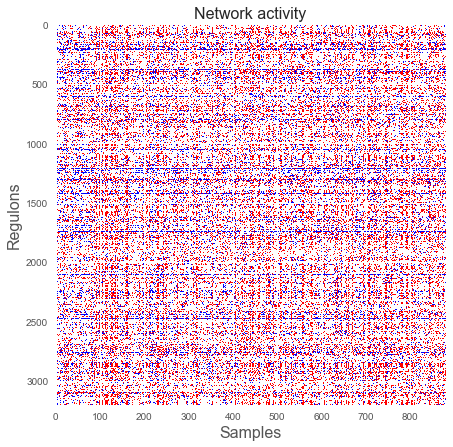

In [1940]:
#visualize network activity across individual samples
plt.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

# 5. Subtype discovery

In [1941]:
reload(miner)
# Infer transcriptional states
minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
primaryMatrix = overExpressedMembersMatrix
primaryDictionary = overExpressedMembers
secondaryMatrix = underExpressedMembersMatrix
secondaryDictionary = underExpressedMembers

states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*expressionData.shape[1])),restricted_index=None)

Beginning subtype inference
completed subtype inference in 2.02 minutes


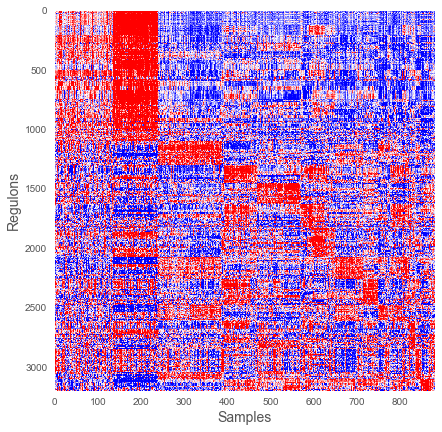

In [1942]:
# Infer transcriptional programs
reload(miner)
reference_df = eigengenes.copy()
programs, _ = miner.mosaic(dfr=eigengenes.copy(),clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = reference_df.loc[np.hstack(program_list),np.hstack(states_)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

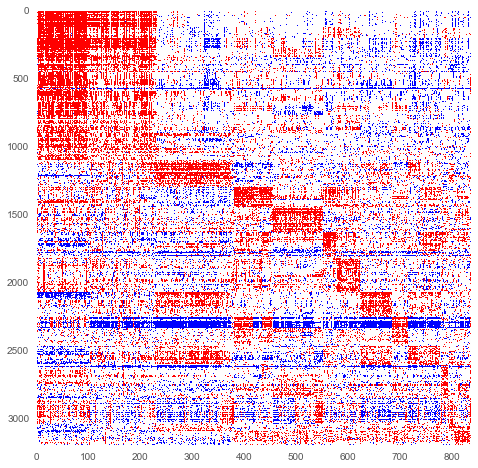

In [1943]:
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
mtrx = dfr.loc[np.hstack(program_list),np.hstack(states)]
plt.figure(figsize=(8,8))
plt.imshow(mtrx,cmap="bwr",vmin=-1,vmax=1,aspect=float(mtrx.shape[1])/float(mtrx.shape[0]))
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"mosaic_all.pdf"),bbox_inches="tight")

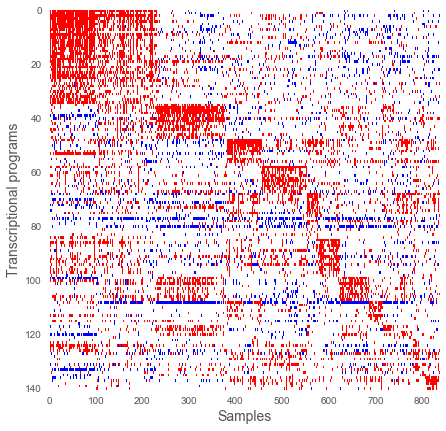

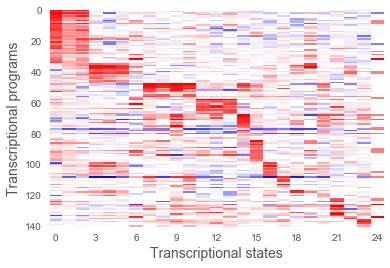

In [1944]:
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=dfr.loc[np.hstack(program_list),np.hstack(states)],programs=program_list,states=states,stateThreshold=0.50,saveFile=os.path.join(resultsDirectory,"transcriptional_programs.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states_predictor.pdf"),showplot=True)

# 6. Risk prediction

## 6a. Risk by subtype

25
10
                                HR       p-value
14&21&9&10&20&7&22        8.153654  3.530909e-16
14&21&9&10&20&7&22&12     8.099834  5.503438e-16
14&21&9&10&20&7           8.025089  1.014526e-15
14&21&9&10                7.673618  1.672121e-14
14&21&9                   7.583758  3.356863e-14
14&21&9&10&20             7.148504  8.772853e-13
14&21&9&10&20&7&22&12&11  7.049209  1.799382e-12
14&21                     6.804965  1.010737e-11
14                        5.829141  5.571350e-09
6                        -0.706905  4.796257e-01
6&5                      -2.039951  4.135524e-02
6&5&19                   -2.131157  3.307624e-02
6&5&19&4                 -2.451148  1.424016e-02
6&5&19&4&16              -3.187646  1.434362e-03
6&5&19&4&16&23           -3.601697  3.161469e-04
6&5&19&4&16&23&17        -3.960213  7.488303e-05
6&5&19&4&16&23&17&13     -4.007845  6.127535e-05
6&5&19&4&16&23&17&13&15  -4.331385  1.481742e-05
completed combinatorial transcriptional state survival analysis

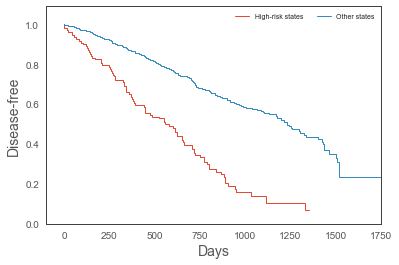

In [1945]:
t1 = time.time()

# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

# Visualize risk associated with each transcriptional state

srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(-np.ones(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)

states = states
mmrf_groups = [i for i in states if len(set(srv.index)&set(i)) >= 1]
labels = range(len(mmrf_groups))

xmedians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        xmedians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        xmedians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(xmedians))

ranked_states = np.argsort(xmedians)

survival_tag = "Risk_groups"

# Combinatorial survival analysis
combined_states, combined_indices = miner.combinedStates(mmrf_groups,ranked_states,srv,minSamples=4,maxStates=10)

state_members = combined_states
sufficient_states = range(len(combined_states))
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_combined_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=1,survivalPath="",survivalData=srv)

cox_hr = [cox_combined_states[i][0] for i in cox_combined_states.keys()]
cox_p = [cox_combined_states[i][1] for i in cox_combined_states.keys()]
cox_combined_states_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_combined_states_df.index = combined_indices
cox_combined_states_df.columns = ["HR","p-value"]
cox_combined_states_df.sort_values(by="HR",ascending=False,inplace=True)
cox_combined_states_df.to_csv(os.path.join(resultsDirectory,"Hazards_regression_of_combined_transcriptional_states.csv"))
print(cox_combined_states_df)

highest_risk_combination = np.array(cox_combined_states_df.index[0].split("&")).astype(int)
lowest_risk_combination = np.array(cox_combined_states_df.index[-1].split("&")).astype(int)

kmTag = "states"
kmFilename = ("_").join([survival_tag,kmTag,".pdf"])
groups = [np.hstack([mmrf_groups[i] for i in highest_risk_combination]),np.hstack([mmrf_groups[i] for i in range(len(mmrf_groups)) if i not in highest_risk_combination])]
labels = np.arange(len(groups)).astype(str)
labels = ["High-risk states","Other states"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),filename=plotName)  

t2 = time.time()
print("completed combinatorial transcriptional state survival analysis in {:.2f} minutes".format((t2-t1)/60.))

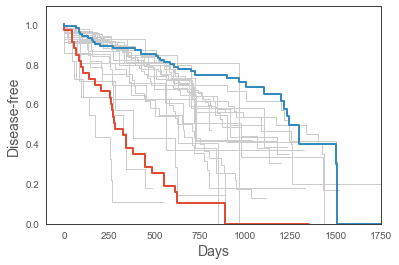

In [1958]:
# Visualize survival of selected transcriptional state combinations

reload(miner)
select_high = [9,10,14,21]
select_low = [4,5,6,16,19]
select_small = [i for i in range(len(states)) if len(set(srv.index)&set(states[i])) <= 3]
select_groups = np.hstack([select_high,select_low,select_small])

kmTag = "all_states"
kmFilename = ("_").join([survival_tag,kmTag,".pdf"])
groups = [mmrf_groups[i] for i in range(len(mmrf_groups))]
labels = np.arange(len(groups)).astype(str)
labels = ["State "+str(i) for i in range(len(groups))]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=None,xlim_=(-100,1750),filename=None,color=[0.8,0.8,0.8])  

groups = [np.hstack([states[i] for i in select_high]),np.hstack([states[i] for i in select_low])]

labels = np.arange(len(groups)).astype(str)
labels = ["High-risk","Low-risk"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=None,xlim_=(-100,1750),filename=None,lw=2)  
plt.savefig(os.path.join(resultsDirectory,"states_survival_all.pdf"),bbox_inches="tight")


21
completed transcriptional state risk analysis in 0.01 minutes


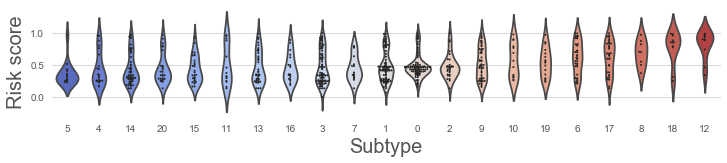

In [1947]:
# Plot risk of transcriptional states using normalized GuanRank

t1 = time.time()

mmrf_groups = [states[i] for i in range(len(states)) if len(set(states[i])&set(srv.index)) >=5]
labels = range(len(mmrf_groups))

xmedians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        xmedians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        xmedians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(xmedians))

ranked_states = np.argsort(xmedians)

survival_tag = "Risk_groups"
plt.figure(figsize=(12,7))

#my_pal = [(1,1-i/float(len(mmrf_groups)),1-i/float(len(mmrf_groups))) for i in range(len(mmrf_groups))]
ordered_medians = np.array(xmedians)[np.argsort(xmedians)]
my_pal = [(ordered_medians[i],1-ordered_medians[i],1-ordered_medians[i]) for i in range(len(mmrf_groups))]

ax = sns.violinplot(x='group', y='value', data=guan_srv_df,order=ranked_states,inner=None,palette=sns.color_palette("coolwarm", len(mmrf_groups)))#palette=my_pal

ax.set_axis_bgcolor([1,1,1])
ax.grid(True,color=[0.85,0.85,0.85])
ax.set_aspect(2)

sns.swarmplot(x='group', y='value',data=guan_srv_df,order=np.argsort(xmedians),size=2, color=[0.15,0.15,0.15],edgecolor="black")
#sns.stripplot(x='group', y='value',data=guan_srv_df,order=np.argsort(xmedians),size=2,color=[0.15,0.15,0.15],edgecolor="black", jitter=False)
    
plt.ylabel("Risk score",FontSize=20)
plt.xlabel("Subtype",FontSize=20)
boxplotFilename = ("_").join([survival_tag,"violinplot_swarm_raw.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")


t2 = time.time()
print("completed transcriptional state risk analysis in {:.2f} minutes".format((t2-t1)/60.))

In [1948]:
# proportional hazards regression of transcriptional programs
cox_programs = miner.parallelMemberSurvivalAnalysis(membershipDf = statesDf,numCores=5,survivalPath="",survivalData=srv)

cox_programs_hr = [cox_programs[i][0] for i in range(len(cox_programs))]
cox_programs_p = [cox_programs[i][1] for i in range(len(cox_programs))]
cox_programs_df = pd.DataFrame(np.vstack([cox_programs_hr,cox_programs_p]).T)
cox_programs_df.index = [cox_programs.keys()[i] for i in range(len(cox_programs))]
cox_programs_df.columns = ["HR","p-value"]
cox_programs_df.sort_values(by="HR",ascending=False,inplace=True)
cox_programs_df.to_csv(os.path.join(resultsDirectory,"cox_programs_hrs.csv"))

# filter the transcriptional programs by p-value cutoff
p_cutoff = 1 #p_cutoff = 1 keeps all transcriptional programs for analysis
filtered_cox = cox_programs_df[cox_programs_df["p-value"]<p_cutoff]
filtered_cox.index

# identify positively-labeled patients for each program
program_status = [
    statesDf.columns[np.where(statesDf.loc[p,:]==1)[0]] for p in filtered_cox.index
]

10
10
10
10
10
20
20
20
20
20


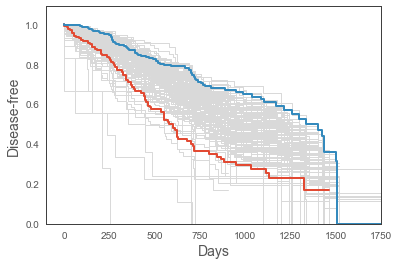

In [1949]:
reload(miner)
select_high = [0] #highlight high-risk states
select_low = [-1] #highlight low-risk states
select_small = [i for i in range(len(program_status)) if len(set(srv.index)&set(program_status[i])) <= 3]
select_groups = np.hstack([select_high,select_low,select_small])
select_groups = select_small

kmTag = "programs"
kmFilename = ("_").join([survival_tag,kmTag,".pdf"])
groups = [program_status[i] for i in range(len(program_status)) if i not in select_groups]
labels = np.arange(len(groups)).astype(str)
labels = ["State "+str(i) for i in range(len(groups))]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=None,xlim_=(-100,1750),filename=None,color=[0.85,0.85,0.85])  

groups = [np.hstack([program_status[i] for i in select_high]),np.hstack([program_status[i] for i in select_low])]

labels = np.arange(len(groups)).astype(str)
labels = ["High-risk","Low-risk"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=None,xlim_=(-100,1750),filename=None,lw=2)  
plt.savefig(os.path.join(resultsDirectory,"programs_survival.pdf"),bbox_inches="tight")


## 6b. Risk by machine-learning classification

## Load expression data

In [1951]:
# define modules to interrogate in test sets
reference_modules = regulonModules

# GSE24080UAMS - test set 1
expressionDataGSE24080UAMS = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","expression_myeloma_20190531","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE24080UAMS,label=2,p=0.1)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)
underExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE24080UAMS,label=0,p=0.1)
underExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(underExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)

# GSE19784HOVON65 - test set 2
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","expression_myeloma_20190531","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE19784HOVON65,label=2,p=0.1)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)
underExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(reference_modules,bkgdGSE19784HOVON65,label=0,p=0.1)
underExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(underExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)

# EMTAB4032 - test set 3
expressionDataEMTAB4032 = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","expression_myeloma_20190531","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(reference_modules,bkgdEMTAB4032,label=2,p=0.1)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)
underExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(reference_modules,bkgdEMTAB4032,label=0,p=0.1)
underExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(underExpressedMembersEMTAB4032,expressionDataEMTAB4032)

# generate discrete network mapping matrices for each dataset
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
dfrGSE24080UAMS = overExpressedMembersMatrixGSE24080UAMS-underExpressedMembersMatrixGSE24080UAMS
dfrGSE19784HOVON65 = overExpressedMembersMatrixGSE19784HOVON65-underExpressedMembersMatrixGSE19784HOVON65
dfrEMTAB4032 = overExpressedMembersMatrixEMTAB4032-underExpressedMembersMatrixEMTAB4032

completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
done!
completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
done!
completed identifier conversion.
17228 genes were converted.
completed z-transformation.
done!
done!


## Load survival data

In [1953]:
survival = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","survival_myeloma_20190531","globalClinTraining.csv"),index_col=0,header=0)

# GSE24080UAMS
survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalDfGSE24080UAMS = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE24080UAMS.columns = ["duration","observed"]
kmDfGSE24080UAMS = miner.kmAnalysis(survivalDf=survivalDfGSE24080UAMS,durationCol="duration",statusCol="observed")
guanSurvivalDfGSE24080UAMS = miner.guanRank(kmSurvival=kmDfGSE24080UAMS)

# GSE19784HOVON65 
survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalDfGSE19784HOVON65 = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE19784HOVON65.columns = ["duration","observed"]
kmDfGSE19784HOVON65 = miner.kmAnalysis(survivalDf=survivalDfGSE19784HOVON65,durationCol="duration",statusCol="observed")
guanSurvivalDfGSE19784HOVON65 = miner.guanRank(kmSurvival=kmDfGSE19784HOVON65)

# EMTAB4032
survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalDfEMTAB4032 = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfEMTAB4032.columns = ["duration","observed"]
kmDfEMTAB4032 = miner.kmAnalysis(survivalDf=survivalDfEMTAB4032,durationCol="duration",statusCol="observed")
guanSurvivalDfEMTAB4032 = miner.guanRank(kmSurvival=kmDfEMTAB4032)

# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","survival_myeloma_20190531","survivalMMRFIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

## Generate predictor

(16, 0.7526573861909034, 5.684165673278644)
classified 11.9 percent of training population as high-risk
classified 9.1 percent of test population as high-risk
16


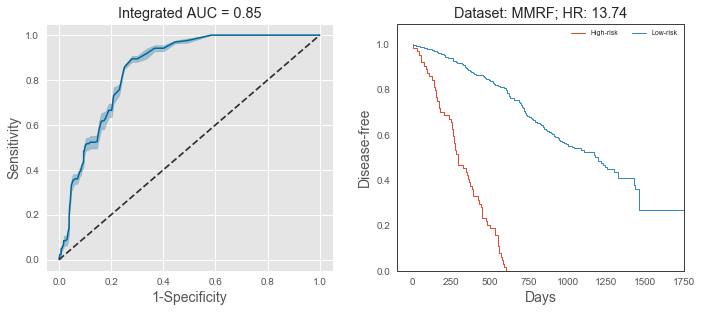

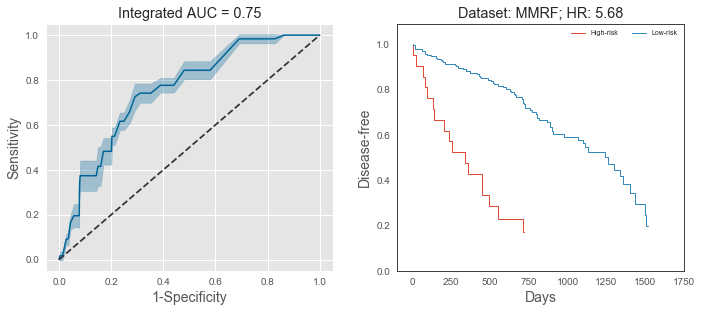

In [1961]:
reload(miner)

membership_datasets = [
    overExpressedMembersMatrix
]

survival_datasets = [
    guanSurvivalDfMMRF
]

dataset_labels = [
    "MMRF"
]


#iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,best_state=13,n_estimators=100,class1_proportion=0.30,test_proportion=0.35
#classifier, class_0, class_1 = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,n_estimators=100,class1_proportion=0.25,best_state=24,test_proportion=0.35)

# best MMRF: classifier, class_0, class_1 = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,n_estimators=100,class1_proportion=0.25,test_proportion=0.3,best_state=12)
# best GSE24080UAMS: classifier, class_0, class_1 = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='roc_auc',separate_results=True,n_estimators=100,class1_proportion=0.25,test_proportion=0.25,best_state=27)
# best GSE19784HOVON65: classifier, class_0, class_1 = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='roc_auc',separate_results=True,n_estimators=100,class1_proportion=0.30,test_proportion=0.25,best_state=3)
# best EMTAB4032: classifier, class_0, class_1 = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='roc_auc',separate_results=True,n_estimators=50,class1_proportion=0.30,test_proportion=0.25,best_state=24)

classifier, class0, class1, mean_aucs, mean_hrs, pct_labeled = miner.generatePredictor(membership_datasets,survival_datasets,dataset_labels,iterations = 30,method='xgboost',output_directory=resultsDirectory,metric='hazard_ratio',separate_results=True,n_estimators=100,class1_proportion=0.25,test_proportion=0.30,best_state=16)

## Evaluate classifications in each separate dataset

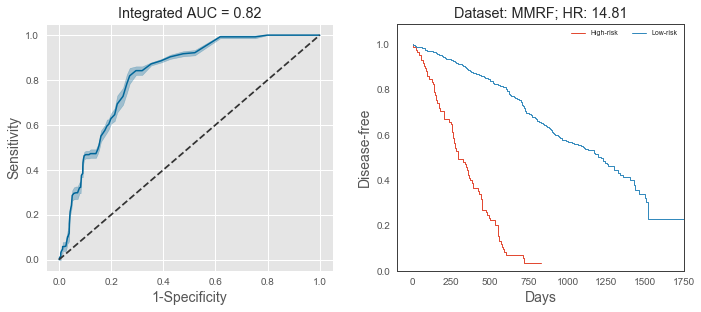

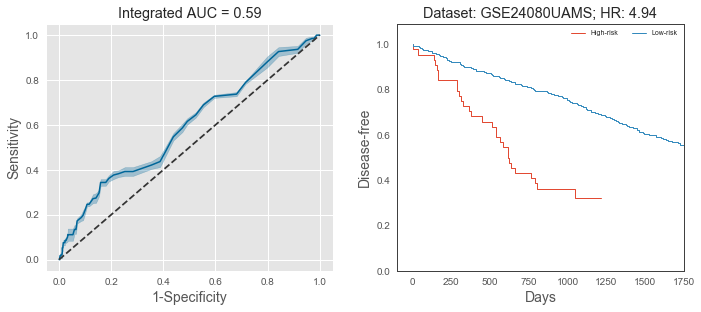

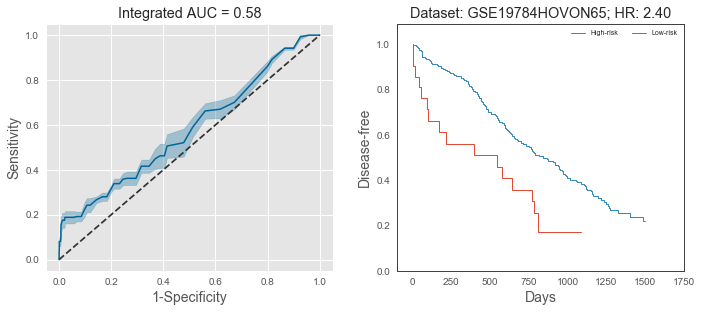

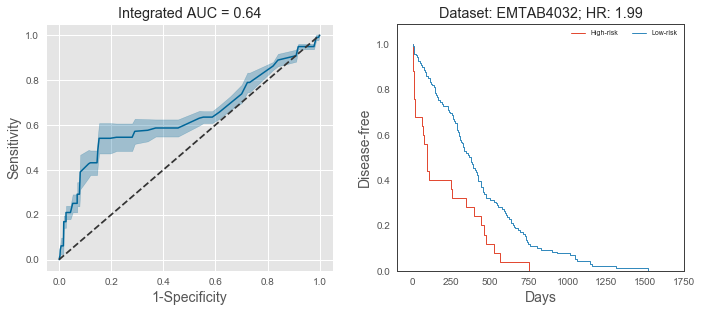

In [1962]:
membership_datasets = [
    overExpressedMembersMatrix,
    overExpressedMembersMatrixGSE24080UAMS,
    overExpressedMembersMatrixGSE19784HOVON65,
    overExpressedMembersMatrixEMTAB4032
]

survival_datasets = [
    guanSurvivalDfMMRF,
    guanSurvivalDfGSE24080UAMS,
    guanSurvivalDfGSE19784HOVON65,
    guanSurvivalDfEMTAB4032
]

dataset_labels = [
    "MMRF",
    "GSE24080UAMS",
    "GSE19784HOVON65",
    "EMTAB4032"
]

predictions = []
for p in range(len(membership_datasets)):
    tmp_predictions = classifier.predict(np.array(membership_datasets[p].T))
    predictions.append(tmp_predictions)

for j in range(len(membership_datasets)):
    mtrx = membership_datasets[j]
    guan_srv = survival_datasets[j]
    survival_tag = dataset_labels[j]
    lbls = predictions[j]
    aucs, cutoffs, tpr_list, fpr_list, hazard_ratio = miner.riskStratification(lbls,mtrx,guan_srv,survival_tag,classifier,guan_rank=False,resultsDirectory=None,plot_all=False,plot_any=True)


## Determine percent predicted high-risk

In [1964]:
# generate predictions for each dataset
reload(miner)
predictor_tag = "IA12"
mmrfIA12_predictions = classifier.predict(np.array(overExpressedMembersMatrix.T))
GSE24080UAMS_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = classifier.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

percent_classified_hr = 100*sum(mmrfIA12_predictions)/float(len(mmrfIA12_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE24080UAMS_predictions)/float(len(GSE24080UAMS_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(GSE19784HOVON65_predictions)/float(len(GSE19784HOVON65_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))
percent_classified_hr = 100*sum(EMTAB4032_predictions)/float(len(EMTAB4032_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))

classified 14.1 percent of population as high-risk
classified 7.9 percent of population as high-risk
classified 7.8 percent of population as high-risk
classified 17.0 percent of population as high-risk


## Visualize decision-tree (decision-tree classifier)

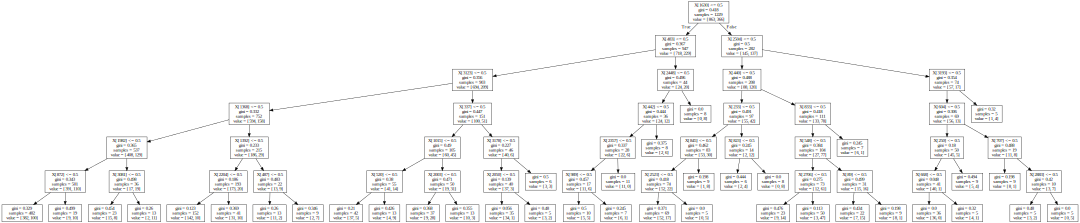

In [1891]:
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot 
from graphviz import Source

dot_data = StringIO() 
tree.export_graphviz(classifier, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
#graph[0].write_pdf(os.path.join(resultsDirectory,"decisionTreeAUC.pdf"))

# visualize decision tree
graph[0].set_graph_defaults(size = "\"15,15\"")
decisionTree = Source(graph[0].to_string())
decisionTree

## Visualize decision-tree (XGBoost classifier)

In [ ]:
plot_tree(classifier, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(50, 10)
# plt.savefig(os.path.join(resultsDirectory,"xgboost_tree_0.pdf"))

## Save predictor

In [362]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_xgboost_predictor_hr.pkl')
pickle.dump(classifier, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8861788617886179


## Investigate feature importance

In [1965]:
# Quantify importance of individual features
rank = 1 # 1 is the most important feature, -1 is the least important non-zero feature
fi = np.array(classifier.feature_importances_)
feature = overExpressedMembersMatrix.index[np.argsort(fi)[-rank]]
print(feature,fi[np.argsort(fi)[-rank]])

('961', 0.048275862)


In [1966]:
# Tabulate important features into dataframe
fi_df = pd.DataFrame(fi)
fi_df.index = overExpressedMembersMatrix.index
fi_df.columns = ["feature_importance"]
fi_df_filtered = fi_df[fi_df["feature_importance"]>0]
fi_df_filtered.index

Index([u'26', u'27', u'55', u'108', u'116', u'159', u'192', u'201', u'224',
       u'246', u'251', u'257', u'331', u'355', u'367', u'398', u'494', u'542',
       u'597', u'625', u'634', u'678', u'711', u'754', u'911', u'961', u'994',
       u'1110', u'1126', u'1155', u'1164', u'1206', u'1242', u'1267', u'1380',
       u'1426', u'1433', u'1472', u'1529', u'1541', u'1553', u'1579', u'1612',
       u'1622', u'1627', u'1633', u'1738', u'1743', u'1750', u'1753', u'1771',
       u'1785', u'1789', u'1795', u'1926', u'1954', u'2045', u'2093', u'2107',
       u'2120', u'2163', u'2164', u'2193', u'2253', u'2273', u'2281', u'2317',
       u'2361', u'2379', u'2427', u'2468', u'2559', u'2666', u'2722', u'2729',
       u'2758', u'2771', u'2820', u'2823', u'2972', u'2997', u'2998', u'3003',
       u'3049', u'3057', u'3105', u'3117', u'3155'],
      dtype='object')

In [1967]:
# List number of times individual genes and regulators appear in important features

allgenes = []
allregulators = []
for reg_id in list(fi_df_filtered.index):
    genes = list(regulonDf_indexed.loc[reg_id,"Gene"])
    regulator = list(regulonDf_indexed.loc[reg_id,"Regulator"])[0]
    allgenes.append(genes)
    allregulators.append(regulator)
    
count_genes = Counter(np.hstack(allgenes))
count_regulators = Counter(allregulators)

genes_mc = count_genes.most_common()
regulators_mc = count_regulators.most_common()
print(genes_mc[0:10],regulators_mc[0:10])

([('ENSG00000113810', 3), ('ENSG00000002919', 3), ('ENSG00000138668', 3), ('ENSG00000274665', 3), ('ENSG00000056277', 3), ('ENSG00000281540', 3), ('ENSG00000144579', 3), ('ENSG00000012048', 3), ('ENSG00000166483', 3), ('ENSG00000103522', 3)], [('ENSG00000196628', 3), ('ENSG00000185591', 2), ('ENSG00000126561', 2), ('ENSG00000184481', 2), ('ENSG00000204103', 2), ('ENSG00000112658', 2), ('ENSG00000126456', 2), ('ENSG00000065970', 2), ('ENSG00000069667', 2), ('ENSG00000131408', 2)])


In [1968]:
# Convert ensembl gene identifiers to gene symbols for quick reference
# requires installation of "mygene"

conv_ = [i[0] for i in genes_mc[0:20]]
#conv_ = [i[0] for i in regulators_mc[0:20]]
#conv_ = list(regulonDf[regulonDf.Regulon_ID==1366]["Gene"])
geneset = miner.gene_conversion(conv_,list_symbols=True)
np.savetxt(os.path.join(resultsDirectory,"geneset.txt"),geneset,fmt="%1.50s")
print(geneset)

querying 1-20...done.
Finished.
[u'TCF4', u'SP1', u'STAT5A', u'FOXO4', u'MAFB', u'SRF', u'IRF3', u'FOXJ2', u'RORA', u'NR1H2', u'IRF1', u'STAT6', u'THRB', u'IRF9', u'CDC5L', u'PBX1', u'NKX3-1', u'FOXK1', u'ZKSCAN3', u'ARID5A']


In [1969]:
# print number of features with non-zero predictive importance
len(important_regulons)

385

# 7. Perform differential network analysis

In [ ]:
# Define phenotypes of interest
all_patients = expressionData.columns
baseline_patients = [pat for pat in all_patients if pat.split("_")[2]=='1']
first_relapse_patients = [pat for pat in all_patients if pat.split("_")[2]=='2']
relapse_patients = [pat for pat in all_patients if pat.split("_")[2]!='1']
multiple_relapse_patients = list(set(relapse_patients)-set(first_relapse_patients))

phenotype1 = baseline_patients
phenotype2 = relapse_patients

In [ ]:
ikzf1 = "ENSG00000185811"
ikzf3 = "ENSG00000161405"
crbn = "ENSG00000113851"
nr3c1 = "ENSG00000113580"
psmb1 = "ENSG00000008018"
psmb5 = "ENSG00000100804"
genelist = [ikzf1,ikzf3,crbn,nr3c1,psmb1,psmb5]

boxplot_data = []
expression_data = []
for gene in genelist:

    regulons_ = [key for key in regulonModules.keys() if gene in regulonModules[key]]
    #regulons_ = np.array(list(set(regulonDf[regulonDf.Regulator==gene]["Regulon_ID"]))).astype(str)

    reference_matrix = eigengenes.copy()

    baseline_regulons = []
    first_relapse_regulons = []
    multiple_relapse_regulons = []
    relapse_regulons = []
    
    for regulon_ in regulons_:
        r, p = stats.spearmanr(expressionData.loc[gene,reference_matrix.columns],reference_matrix.loc[regulon_,:])
        edge_direction = r/np.abs(float(r))
        #edge_direction = 1
        #baseline_values = np.mean(np.mean(expressionData.loc[regulonModules[regulon_],baseline_patients],axis=0))
        #relapse_values = np.mean(np.mean(expressionData.loc[regulonModules[regulon_],relapse_patients],axis=0))
        baseline_values = edge_direction*np.mean(reference_matrix.loc[regulon_,phenotype1])
        baseline_regulons.append(baseline_values)
        relapse_values = edge_direction*np.mean(reference_matrix.loc[regulon_,phenotype2])
        relapse_regulons.append(relapse_values)    
        #print(relapse_values)
    boxplot_data.append(baseline_regulons)
    boxplot_data.append(relapse_regulons)
    expression_data.append(expressionData.loc[gene,phenotype1])
    expression_data.append(expressionData.loc[gene,phenotype2])

fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor([0.95,0.95,0.95])

plt.boxplot(boxplot_data)
plt.ylim(-0.7,0.6)
plt.title("Differential network activity",FontSize = 14)
plt.ylabel("Relative activity",FontSize = 14)
#plt.savefig(os.path.join(resultsDirectory,"differential_activity_"+(";").join(genelist)+".pdf"),bbox_inches="tight")

fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor([0.95,0.95,0.95])
plt.boxplot(expression_data)
plt.title("Differential expression",FontSize = 14)
plt.ylabel("Relative expression",FontSize = 14)
#plt.savefig(os.path.join(resultsDirectory,"differential_expression_"+(";").join(genelist)+".pdf"),bbox_inches="tight")

In [ ]:
#Visualize differential network activity
reload(miner)
targets = [ikzf1,ikzf3,crbn,nr3c1,psmb1,psmb5]
volcano_data_3 = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 3,minRegulons = 3,useAllRegulons = False,highlight = targets,savefile = os.path.join(resultsDirectory,"baseline_vs_relapse_top3regulons.pdf"))
volcano_data_ = volcano_data_3.copy()

insigvoldata_patients = volcano_data_.index[volcano_data_["-log10(p)"]<=-np.log10(0.05)]
sigvoldata_patients = volcano_data_.index[volcano_data_["-log10(p)"]>-np.log10(0.05)]

insigvoldata = volcano_data_.loc[insigvoldata_patients,:]
sigvoldata = volcano_data_.loc[sigvoldata_patients,:]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor([0.95,0.95,0.95])
#ax.grid(color=[0.9,0.9,0.9])
ax.scatter(sigvoldata["phenotype2_frequency"],np.array(sigvoldata["log2(phenotype2/phenotype1)"]),color = [0,0.5,1],edgecolor = [0,0.2,0.4],alpha=0.5,s=10)
ax.scatter(insigvoldata["phenotype2_frequency"],np.array(insigvoldata["log2(phenotype2/phenotype1)"]),color = [0.2,0.2,0.2],edgecolor = [0.1,0.1,0.1],alpha=0.5,s=10)
ax.scatter(volcano_data_.loc[ikzf1,"phenotype2_frequency"],np.array(volcano_data_.loc[ikzf1,"log2(phenotype2/phenotype1)"]),color = [0.9,0.0,0.0],edgecolor=[0.8,0.4,0.4],s=10)
#ax.scatter(volcano_data_.loc[phf19,"phenotype2_frequency"],np.array(volcano_data_.loc[phf19,"log2(phenotype2/phenotype1)"]),color = "red",edgecolor="blue",s=5)

#plt.ylim(-2.8,2.4)
plt.ylabel("log2(Relapse/Baseline)",FontSize=14)
plt.xlabel("Overexpression frequency at relapse",FontSize=14)
#plt.savefig(os.path.join(resultsDirectory,"differential_network_volcano.pdf"),bbox_inches="tight")

# 8. Visualize with tSNE

completed tsne visualization in 0.35 minutes


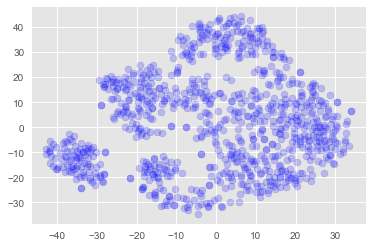

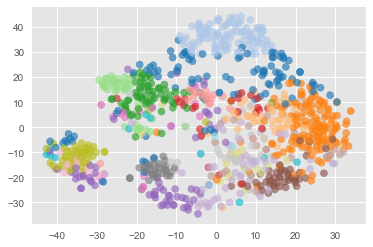

In [265]:
t1 = time.time()

# tSNE applied to expressionData. Set plotOnly = False to return tSNE coordinates
# consider changing the perplexity to explore different degrees of cluster separation
# miner.tsne(expressionData,perplexity=15,n_components=2,n_iter=1000,plotOnly=True,plotColor="red",alpha=0.4)
# plt.savefig(os.path.join(resultsDirectory,"tsne_gene_expression.pdf"),bbox_inches="tight")

# tSNE applied to df_for_tsne. Consider changing the perplexity in the range of 5 to 50
df_for_tsne = reference_df.copy()
plt.figure()
X_embedded = miner.tsne(df_for_tsne,perplexity=30,n_components=2,n_iter=1000,plotOnly=None,plotColor="blue",alpha=0.2)
tsneDf = pd.DataFrame(X_embedded)
tsneDf.index = df_for_tsne.columns
tsneDf.columns = ["tsne1","tsne2"]
plt.savefig(os.path.join(resultsDirectory,"tsne_regulon_activity.pdf"),bbox_inches="tight")

# convert states to tsne labels

state_labels = miner.tsneStateLabels(tsneDf,states)

# overlay states cluster labels
plt.figure()
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="tab20",c=state_labels,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_states.pdf"),bbox_inches="tight")

# overlay activity of transcriptional programs
#miner.plotStates(statesDf,tsneDf,numCols=int(np.sqrt(statesDf.shape[0])),saveFile = os.path.join(resultsDirectory,("_").join(["states_regulons",("").join(["0o",str(minCorrelation).split(".")[1]]),"tsne.pdf"])),aspect=1,size=10,scale=3)

t2 = time.time()
print("completed tsne visualization in {:.2f} minutes".format((t2-t1)/60.))


# END DEMO

## Reference matrices of random regulons

In [1746]:
tf_to_targets = miner.read_pkl(os.path.join(os.path.split(os.getcwd())[0],"data","network_dictionaries",mechanistic_database))

In [1762]:
# Make random regulons
tfs = list(regulonDf.Regulator.unique())

random_regulons = {}
for tf in tfs:
    regs = list(set(regulator_indexed_rdf.loc[tf,"Regulon_ID"]))
    for i in range(len(regs)):
        reg_length = len(regulonModules[str(regs[i])])
        #random_reg = np.random.choice(tf_to_targets[tf],reg_length,replace=False)
        random_reg = np.random.choice(expressionData.index,reg_length,replace=False)        
        random_regulons[str(len(random_regulons))] = random_reg
    

In [1797]:
reference_modules = random_regulons
overExpressedMembersRandom = miner.biclusterMembershipDictionary(reference_modules,bkgd,label=2,p=0.05)
overExpressedMembersMatrixRandom  = miner.membershipToIncidence(overExpressedMembersRandom,expressionData)
underExpressedMembersRandom  = miner.biclusterMembershipDictionary(reference_modules,bkgd,label=0,p=0.05)
underExpressedMembersMatrixRandom  = miner.membershipToIncidence(underExpressedMembersRandom,expressionData)

done!
done!


In [ ]:
tf_inDegree = Counter(regulonDf.Regulator)

In [ ]:
tf_outDegree_genes = {}
for reg in list(regulonDf.Regulator.unique()):
    regdf_subset = regulonDf[regulonDf.Regulator==reg]
    tf_outDegree_genes[reg] = len(regdf_subset.Gene.unique())
    
print(tf_outDegree_genes["ENSG00000112592"])

In [ ]:
tf_inDegree_genes = {}
for reg in list(regulonDf.Regulator.unique()):
    try:
        regdf_subset = regulonDf[regulonDf.Gene==reg]
        degree = len(regdf_subset.Regulator.unique())
        tf_inDegree_genes[reg] = degree
    except:
        tf_inDegree_genes[reg] = 0
        
    
print(tf_inDegree_genes["ENSG00000112592"])

In [ ]:
gene = "ENSG00000185591"
reference_matrix = eigengenes.copy()
downstream_activity = []
upstream_activity = []
downstream_tfs = []
upstream_tfs = []

for gene in list(set(regulonDf.Regulator.unique())):
    regulons_out = []
    regulons_ = np.array(list(set(regulonDf[regulonDf.Regulator==gene]["Regulon_ID"]))).astype(str)
    for regulon_ in regulons_:
        r, p = stats.spearmanr(expressionData.loc[gene,reference_matrix.columns],reference_matrix.loc[regulon_,:])
        edge_direction = r/np.abs(float(r))
        relapse_values = list(edge_direction*reference_matrix.loc[regulon_,:])
        regulons_out.append(relapse_values)     

    outward = np.mean(np.vstack(regulons_out),axis=0)
    downstream_activity.append(outward)
    downstream_tfs.append(gene)

    regulons_in = []
    regulons_ = np.array(list(set(regulonDf[regulonDf.Gene==gene]["Regulon_ID"]))).astype(str)
    if len(regulons_) >0: 
        for regulon_ in regulons_:
            relapse_values = list(reference_matrix.loc[regulon_,:])
            regulons_in.append(relapse_values)    

        inward = np.mean(np.vstack(regulons_in),axis=0)
        upstream_activity.append(inward)
        upstream_tfs.append(gene)

tf_downstream_activity = pd.DataFrame(np.vstack(downstream_activity))
tf_downstream_activity.index = downstream_tfs
tf_downstream_activity.columns = reference_matrix.columns

tf_upstream_activity = pd.DataFrame(np.vstack(upstream_activity))
tf_upstream_activity.index = upstream_tfs
tf_upstream_activity.columns = reference_matrix.columns


In [ ]:
tf_upstream_activity

In [ ]:
reload(miner)
survival_results_downstream = miner.parallelSurvivalAnalysis(tf_downstream_activity,survivalDfMMRF,numCores=5)
survival_results_upstream = miner.parallelSurvivalAnalysis(tf_upstream_activity,survivalDfMMRF,numCores=5)

In [ ]:
common_keys = list(set(survival_results_downstream.keys())&set(survival_results_upstream.keys()))

In [ ]:
survival_values_downstream = [survival_results_downstream[key][0] for key in common_keys]
survival_values_upstream = [survival_results_upstream[key][0] for key in common_keys]
plt.scatter(survival_values_upstream,survival_values_downstream)

In [ ]:
survival_upstream_results_df = pd.DataFrame(survival_results_upstream)
survival_upstream_results_df.index = survival_results_upstream.keys()
survival_upstream_results_df.columns = ["upstream_hazard"]

survival_downstream_results_df = pd.DataFrame(survival_results_downstream)
survival_downstream_results_df.index = survival_results_downstream.keys()
survival_downstream_results_df.columns = ["downstream_hazard"]

In [ ]:
# infer impact of mutations of epigenetic regulators
epigenetic_file = os.path.join(os.path.split(os.getcwd())[0],"data","epigenes.txt")
epigenetic_regulators = pd.read_csv(epigenetic_file,index_col=None,header=None,sep="\t")
epigenetic_regulators = list(epigenetic_regulators[0])
epigenetic_impact = miner.causalNetworkImpact(epigenetic_regulators,regulonDf,expressionData,eigengenes,translocations,resultsDirectory,minRegulons=1,significance_threshold=0.05,causalFolder="epigenetic_results",return_df=True,tag=None)

In [ ]:
survival_upstream_results_df

In [ ]:
test1 = survival_upstream_results_df.index[np.where(survival_upstream_results_df.iloc[:,0]>-1)[0]]
test2 = survival_downstream_results_df.index[np.where(survival_downstream_results_df.iloc[:,0]<-2)[0]]
print(list(set(test1)&set(test2)))

In [ ]:
miner.gene_conversion(survival_downstream_results_df.index[np.where(survival_downstream_results_df.iloc[:,0]>4)[0]],list_symbols=True)

In [662]:
gene_dependency = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","gene_dependency_corrected.csv"),index_col=0,header=0)

## Validate network with CRISPR KO data

In [751]:
# gene_dependency = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","gene_dependency_corrected.csv"),index_col=0,header=0)
# gene_dependency_celllines = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","DepMap-2019q1-celllines_v2.csv"),index_col=0,header=0)
# myeloma_cell_lines_df = gene_dependency_celllines[gene_dependency_celllines["Primary Disease"]=="Myeloma"]
# myeloma_cell_lines = list(myeloma_cell_lines_df.index)
# represented_mm_cell_lines = list(set(set(gene_dependency.index)&set(myeloma_cell_lines)))
# myeloma_cell_lines_df = myeloma_cell_lines_df.loc[represented_mm_cell_lines,:]
# myeloma_cell_lines_df["CCLE_Name"]

# myeloma_gene_dependency = gene_dependency.loc[list(set(set(gene_dependency.index)&set(myeloma_cell_lines))),:]

# achilles_genes = [name.split(" ")[-1] for name in myeloma_gene_dependency.columns]
# achilles_genes = [name.split("(")[-1] for name in achilles_genes]
# achilles_genes = [name.split(")")[0] for name in achilles_genes]

# achilles_genes_ensembl = miner.gene_conversion(achilles_genes,input_type="entrezgene",output_type="ensembl")

# reference_ensembl = set(expressionData.index)

# achilles_entrez = []
# achilles_ensembl = []
# for gene in achilles_genes_ensembl.keys():
#     ensembl_list = achilles_genes_ensembl[gene]
#     if len(ensembl_list)>1:
#         ensembl = list(set(ensembl_list)&reference_ensembl)
#         if len(ensembl)>=1:
#             ensembl = ensembl[0]
#         elif len(ensembl)==0:
#             ensembl = ensembl_list[0]
#     elif len(ensembl_list)==1:
#         ensembl = ensembl_list[0]
#     achilles_entrez.append(gene)
#     achilles_ensembl.append(ensembl)
    
# myeloma_gene_dependency.columns = achilles_genes
# myeloma_gene_dependency = myeloma_gene_dependency.loc[:,achilles_entrez]
# myeloma_gene_dependency.columns = achilles_ensembl


t414_positive_cell_lines = ["ACH-000714","ACH-000658","ACH-000588","ACH-000541","ACH-000204"]
t414_negative_cell_lines = ["ACH-000576","ACH-000512","ACH-000436","ACH-000763","ACH-000653"]

dependency_t414_positive = myeloma_gene_dependency.loc[t414_positive_cell_lines,:]
dependency_t414_negative = myeloma_gene_dependency.loc[t414_negative_cell_lines,:]

t414_ttest = stats.ttest_ind(dependency_t414_positive,dependency_t414_negative,axis=0,equal_var=False)

t414_ttest_df = pd.DataFrame(np.vstack(t414_ttest).T)
t414_ttest_df.columns = ["t-statistic","p-value"]
t414_ttest_df.index = achilles_ensembl
t414_ttest_df.sort_values(by="t-statistic",ascending=False,inplace=True)

t414_ttest_df.head()

,t-statistic,p-value
ENSG00000182898,6.950637,0.000132
ENSG00000115904,5.648293,0.003076
ENSG00000161642,4.980172,0.004164
ENSG00000156052,4.896612,0.002877
ENSG00000052344,4.651848,0.004782


In [733]:
myeloma_cell_lines_df

,CCLE_Name,Aliases,COSMIC_ID,Sanger ID,Primary Disease,Subtype Disease,Gender,Source
DepMap_ID,,,,,,,,
ACH-000541,KMS34_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMS-34,NaN,NaN,Myeloma,Multiple Myeloma,Female,HSRRB
ACH-000763,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,1659818.0,995.0,Myeloma,Multiple Myeloma,NaN,Academic Lab
ACH-000512,INA6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,INA-6,NaN,NaN,Myeloma,Multiple Myeloma,NaN,NaN
ACH-000436,OCIMY7_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,OCI-MY7,NaN,NaN,Myeloma,Multiple Myeloma,-1,NaN
ACH-000889,KMM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,NaN,Myeloma,Multiple Myeloma,Male,HSSRB
ACH-000426,KMS20_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMS-20,NaN,NaN,Myeloma,Multiple Myeloma,Female,HSRRB
ACH-000817,RPMI8226_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,905964.0,705.0,Myeloma,"Multiple Myeloma, plasmacytoma",Male,ATCC
ACH-000821,EJM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,1297447.0,567.0,Myeloma,Multiple Myeloma,Female,DSMZ
ACH-000658,KMS18_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,NaN,Myeloma,Multiple Myeloma,NaN,ATCC


In [753]:
differential_ceres_t414 = t414_ttest_df[t414_ttest_df["p-value"]<=0.05].index
list(differential_ceres_t414)

['ENSG00000182898',
 'ENSG00000115904',
 'ENSG00000161642',
 'ENSG00000156052',
 'ENSG00000052344',
 'ENSG00000243719',
 'ENSG00000039523',
 'ENSG00000281917',
 'ENSG00000276469',
 'ENSG00000181036',
 'ENSG00000165819',
 'ENSG00000196475',
 'ENSG00000161664',
 'ENSG00000122012',
 'ENSG00000121552',
 'ENSG00000177885',
 'ENSG00000140986',
 'ENSG00000048162',
 'ENSG00000254470',
 'ENSG00000274684',
 'ENSG00000141449',
 'ENSG00000124067',
 'ENSG00000134910',
 'ENSG00000281661',
 'ENSG00000108387',
 'ENSG00000005844',
 'ENSG00000094914',
 'ENSG00000068305',
 'ENSG00000157014',
 'ENSG00000131781',
 'ENSG00000175544',
 'ENSG00000149260',
 'ENSG00000197860',
 'ENSG00000157593',
 'ENSG00000019991',
 'ENSG00000125898',
 'ENSG00000184857',
 'ENSG00000101109',
 'ENSG00000075399',
 'ENSG00000128581',
 'ENSG00000188322',
 'ENSG00000148346',
 'ENSG00000060688',
 'ENSG00000149084',
 'ENSG00000144579',
 'ENSG00000157992',
 'ENSG00000161860',
 'ENSG00000158480',
 'ENSG00000125970',
 'ENSG00000137992',


completed in 2.24 minutes


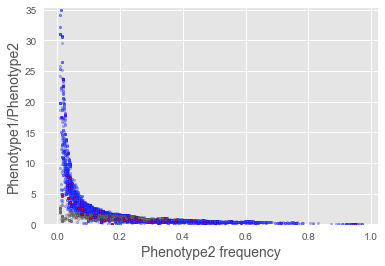

In [754]:
non_t414_patients = translocations.columns[np.where(translocations.loc["RNASeq_WHSC1_Call",:]==0)[0]]
t414_patients = translocations.columns[np.where(translocations.loc["RNASeq_WHSC1_Call",:]==1)[0]]
differential_network_activity_t414 = miner.differentialActivity(regulonDf,overExpressedMembersMatrix.copy(),non_t414_patients,t414_patients,minRegulons = 3,useAllRegulons = False,maxRegulons = 3,highlight=differential_ceres_t414,savefile = None)

In [765]:
dna_t414_ceres_5 = differential_network_activity_t414.loc[differential_ceres_t414,:]
dna_t414_ceres_5 = dna_t414_ceres_5[dna_t414_ceres_5["-log10(p)"]>0]
dna_t414_ceres_5_hits = dna_t414_ceres_5[dna_t414_ceres_5["-log10(p)"]>-np.log10(1e-20)]

print(dna_t414_ceres_5.shape[0],dna_t414_ceres_5_hits.shape[0])

(93, 7)


In [766]:
dna_t414_5 = differential_network_activity_t414[differential_network_activity_t414["-log10(p)"]>0]
dna_t414_5_hits = differential_network_activity_t414[differential_network_activity_t414["-log10(p)"]>-np.log10(1e-20)]

print(dna_t414_5.shape[0],dna_t414_5_hits.shape[0])

(4666, 317)


In [767]:
miner.hyper(dna_t414_5.shape[0],dna_t414_5_hits.shape[0],dna_t414_ceres_5.shape[0],dna_t414_ceres_5_hits.shape[0])

0.44684316017130865

In [ ]:
# tfActivity_expression
# tfActivity_incoming
# tfActivity_outgoing
# tfActivity_leastSquares

sp1_out = pd.DataFrame(sp1_outward)
sp1_out.index = expressionData.columns
sp1_out.columns = ["tfActivity_outdegree"]

plt.figure()
plt.boxplot([expressionData.loc[gene,baseline_patients],expressionData.loc[gene,relapse_patients]])

plt.figure()
plt.boxplot([sp1_in.loc[baseline_patients,"tfActivity_indegree"],sp1_in.loc[relapse_patients,"tfActivity_indegree"]])

if len(regulons_) >0: 
    sp1_in = pd.DataFrame(sp1_inward)
    sp1_in.index = expressionData.columns
    sp1_in.columns = ["tfActivity_indegree"]

    plt.figure()
    plt.boxplot([sp1_out.loc[baseline_patients,"tfActivity_outdegree"],sp1_out.loc[relapse_patients,"tfActivity_outdegree"]])


In [ ]:
transcriptionFactors = list(regulonDf.Regulator.unique())
tfActivity_inDegree = miner.causalNetworkImpact(epigenetic_regulators,regulonDf,expressionData,eigengenes,translocations,resultsDirectory,minRegulons=1,significance_threshold=0.05,causalFolder="epigenetic_results",return_df=True,tag=None)

# 5-alternative. Subtype discovery

Discovered 27 transcriptional states and 141 transcriptional programs
sample coverage within sufficiently large states: 96.9%
completed subtype inference in 6.41 minutes


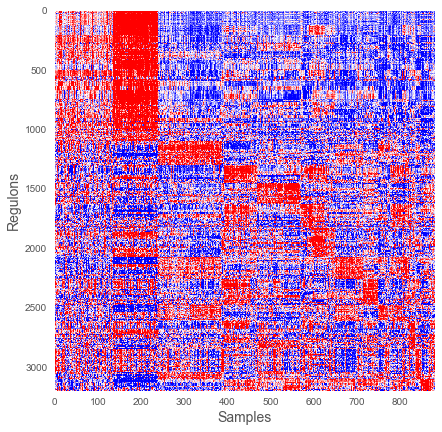

In [1816]:
reload(miner)
t1 = time.time()
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix
sampleUnderMatrix = underExpressedMembersMatrix

# perform initial subtype clustering
similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

# visualize initial results
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
#miner.plotSimilarity(similarityMatrix,np.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"similarityMatrix_regulons.pdf"))

# expand initial subtype clusters
centroidClusters, centroidMatrix = miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

# visualize expanded subtype clusters
#miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"centroidClusters_regulons.pdf"))

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)

#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

# Generate heatmaps of module activity
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Regulons",resultsDirectory=None,showplot=False)
orderedDM = miner.plotDifferentialMatrix(sampleMatrix,sampleUnderMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(resultsDirectory,"centroid_clusters_heatmap.pdf"),showplot=False)
reference_df = eigengenes.loc[predictiveRegulons,:]
#reference_df = orderedDM.copy()

# Infer transcriptional programs and states
programs, states = miner.mosaic(dfr=reference_df,clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = orderedDM.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

# calculate percent of samples that fall into a state with >= minimum acceptable number of samples
groups = [states[i] for i in range(len(states)) if len(states[i])>=int(np.ceil(0.01*expressionData.shape[1]))]
print('Discovered {:d} transcriptional states and {:d} transcriptional programs'.format((len(states)),len(transcriptional_programs)))
print('sample coverage within sufficiently large states: {:.1f}%'.format(100*float(len(np.hstack(groups)))/expressionData.shape[1]))

#write all transcriptional program genesets to text files for external analysis
if not os.path.isdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules")):
    os.mkdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules"))
    
for tp in transcriptional_programs.keys():
    np.savetxt(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules",(".").join([tp,"txt"])),transcriptional_programs[tp],fmt="%1.50s")
    
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=reference_df,programs=program_list,states=states,stateThreshold=0.65,saveFile=None)

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=None)

t2 = time.time()
print("completed subtype inference in {:.2f} minutes".format((t2-t1)/60.))

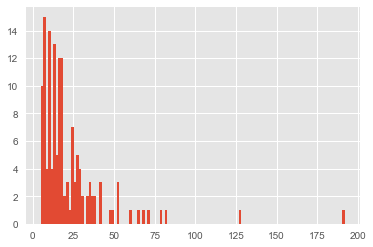

In [1832]:
_ = plt.hist([len(p) for p in program_list],bins=120)

In [1286]:
tmp_centroids = miner.getCentroids(states,overExpressedMembersMatrix-underExpressedMembersMatrix)

arrange_programs = [[] for i in range(len(states))]

for i in range(len(program_list)):
    tmp_mean = np.array(np.mean(tmp_centroids.loc[program_list[i],:],axis=0))
    match = np.argsort(tmp_mean)[-1]
    arrange_programs[match].append(i)

arrange_programs = np.hstack(arrange_programs).astype(int)
program_list = [program_list[i] for i in arrange_programs]

## Generate eigengene matrices

In [481]:
eigengenesGSE24080UAMS = miner.getEigengenes(referenceDictionary,expressionDataGSE24080UAMS,regulon_dict=None,saveFolder=None)
eigenScaleGSE24080UAMS = np.percentile(expressionDataGSE24080UAMS,95)/np.percentile(eigengenesGSE24080UAMS,95)
eigengenesGSE24080UAMS = eigenScaleGSE24080UAMS*eigengenesGSE24080UAMS
eigengenesGSE24080UAMS.index = np.array(eigengenesGSE24080UAMS.index).astype(str)

eigengenesGSE19784HOVON65 = miner.getEigengenes(referenceDictionary,expressionDataGSE19784HOVON65,regulon_dict=None,saveFolder=None)
eigenScaleGSE19784HOVON65 = np.percentile(expressionDataGSE19784HOVON65,95)/np.percentile(eigengenesGSE19784HOVON65,95)
eigengenesGSE19784HOVON65 = eigenScaleGSE19784HOVON65*eigengenesGSE19784HOVON65
eigengenesGSE19784HOVON65.index = np.array(eigengenesGSE19784HOVON65.index).astype(str)

eigengenesEMTAB4032 = miner.getEigengenes(referenceDictionary,expressionDataEMTAB4032,regulon_dict=None,saveFolder=None)
eigenScaleEMTAB4032 = np.percentile(expressionDataEMTAB4032,95)/np.percentile(eigengenesEMTAB4032,95)
eigengenesEMTAB4032 = eigenScaleEMTAB4032*eigengenesEMTAB4032
eigengenesEMTAB4032.index = np.array(eigengenesEMTAB4032.index).astype(str)

In [537]:
eigengenes_bkgd = miner.backgroundDf(expressionData=eigengenes.copy())

In [538]:
eigenmodules = {i:program_list[i] for i in range(len(program_list))}

In [545]:
eigengenesBkgd = miner.backgroundDf(expressionData=eigengenes.copy())
overExpressedMembersEigengenes = miner.biclusterMembershipDictionary(eigenmodules,eigengenes_bkgd,label=2,p=0.05)
overExpressedMembersEigengenesMatrix = miner.membershipToIncidence(overExpressedMembersEigengenes,eigengenes)
underExpressedMembersEigengenes = miner.biclusterMembershipDictionary(eigenmodules,eigengenes_bkgd,label=0,p=0.05)
underExpressedMembersEigengenesMatrix = miner.membershipToIncidence(underExpressedMembersEigengenes,eigengenes)
dfrEigengenes = overExpressedMembersEigengenesMatrix-underExpressedMembersEigengenesMatrix

eigengenesBkgdGSE19784HOVON65 = miner.backgroundDf(expressionData=eigengenesGSE19784HOVON65.copy())
overExpressedMembersEigengenesGSE19784HOVON65 = miner.biclusterMembershipDictionary(eigenmodules,eigengenesBkgdGSE19784HOVON65,label=2,p=0.1)
overExpressedMembersEigengenesMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersEigengenesGSE19784HOVON65,eigengenesGSE19784HOVON65)
underExpressedMembersEigengenesGSE19784HOVON65 = miner.biclusterMembershipDictionary(eigenmodules,eigengenesBkgdGSE19784HOVON65,label=0,p=0.1)
underExpressedMembersEigengenesMatrixGSE19784HOVON65 = miner.membershipToIncidence(underExpressedMembersEigengenesGSE19784HOVON65,eigengenesGSE19784HOVON65)
dfrEigengenesGSE19784HOVON65 = overExpressedMembersEigengenesMatrixGSE19784HOVON65-underExpressedMembersEigengenesMatrixGSE19784HOVON65

eigengenesBkgdGSE24080UAMS = miner.backgroundDf(expressionData=eigengenesGSE24080UAMS.copy())
overExpressedMembersEigengenesGSE24080UAMS = miner.biclusterMembershipDictionary(eigenmodules,eigengenesBkgdGSE24080UAMS,label=2,p=0.1)
overExpressedMembersEigengenesMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersEigengenesGSE24080UAMS,eigengenesGSE24080UAMS)
underExpressedMembersEigengenesGSE24080UAMS = miner.biclusterMembershipDictionary(eigenmodules,eigengenesBkgdGSE24080UAMS,label=0,p=0.1)
underExpressedMembersEigengenesMatrixGSE24080UAMS = miner.membershipToIncidence(underExpressedMembersEigengenesGSE24080UAMS,eigengenesGSE24080UAMS)
dfrEigengenesGSE24080UAMS = overExpressedMembersEigengenesMatrixGSE24080UAMS-underExpressedMembersEigengenesMatrixGSE24080UAMS

eigengenesBkgdEMTAB4032 = miner.backgroundDf(expressionData=eigengenesEMTAB4032.copy())
overExpressedMembersEigengenesEMTAB4032 = miner.biclusterMembershipDictionary(eigenmodules,eigengenesBkgdEMTAB4032,label=2,p=0.1)
overExpressedMembersEigengenesMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEigengenesEMTAB4032,eigengenesEMTAB4032)
underExpressedMembersEigengenesEMTAB4032 = miner.biclusterMembershipDictionary(eigenmodules,eigengenesBkgdEMTAB4032,label=0,p=0.1)
underExpressedMembersEigengenesMatrixEMTAB4032 = miner.membershipToIncidence(underExpressedMembersEigengenesEMTAB4032,eigengenesEMTAB4032)
dfrEigengenesEMTAB4032 = overExpressedMembersEigengenesMatrixEMTAB4032-underExpressedMembersEigengenesMatrixEMTAB4032


done!
done!
done!
done!
done!
done!
done!
done!


In [947]:
genelist = [hdac1,hdac2,hdac3,hdac4,hdac5,hdac6,hdac7,hdac8,hdac9,hdac10]
for i in range(len(genelist)):
    gene = genelist[i]
    if gene in expressionData.index:
        print(i)

0
1
2
3
4
5
6
7
8
9


In [1370]:
ikzf1 = "ENSG00000185811"
ikzf3 = "ENSG00000161405"
crbn = "ENSG00000113851"
nr3c1 = "ENSG00000113580"
psmb1 = "ENSG00000008018"
psmb5 = "ENSG00000100804"

psmb1 = "ENSG00000008018"
psmb2 = "ENSG00000126067"
#psmb3 = "ENSG00000277791"
psmb4 = "ENSG00000159377"
psmb5 = "ENSG00000100804"
psmb6 = "ENSG00000142507"
psmb7 = "ENSG00000136930"
#psmb8 = "ENSG00000204264"
#psmb9 = "ENSG00000240065"

nr3c1 = "ENSG00000113580"
nr1i2 = "ENSG00000144852"
anxa1 = "ENSG00000135046"    
nr0b1 = "ENSG00000169297"

hdac1 = "ENSG00000116478"
hdac2 = "ENSG00000196591"
hdac3 = "ENSG00000171720"
hdac4 = "ENSG00000068024"
hdac5 = "ENSG00000108840"
hdac6 = "ENSG00000094631"
hdac7 = "ENSG00000061273"
hdac8 = "ENSG00000147099"
hdac9 = "ENSG00000048052"
hdac10 = "ENSG00000100429"

bcl2 = "ENSG00000171791"
mcl1 = "ENSG00000143384"
il6 = "ENSG00000136244"
il6r = "ENSG00000160712"
il6st = "ENSG00000134352"
il32 = "ENSG00000008517"

ptgs2 = "ENSG00000073756"
TNFRSF11 = "ENSG00000120659"

False

Text(0,0.5,u'Relative expression')

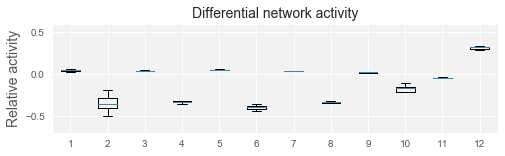

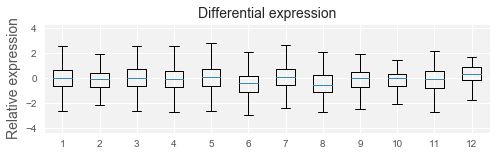

In [1846]:
ikzf1 = "ENSG00000185811"
ikzf3 = "ENSG00000161405"
crbn = "ENSG00000113851"
nr3c1 = "ENSG00000113580"
psmb1 = "ENSG00000008018"
psmb5 = "ENSG00000100804"
genelist = [ikzf1,ikzf3,crbn,nr3c1,psmb1,psmb5]

boxplot_data = []
expression_data = []
for gene in genelist:

    regulons_ = [key for key in regulonModules.keys() if gene in regulonModules[key]]
    #regulons_ = np.array(list(set(regulonDf[regulonDf.Regulator==gene]["Regulon_ID"]))).astype(str)

    reference_matrix = eigengenes.copy()

    baseline_regulons = []
    first_relapse_regulons = []
    multiple_relapse_regulons = []
    relapse_regulons = []
    
    for regulon_ in regulons_:
        r, p = stats.spearmanr(expressionData.loc[gene,reference_matrix.columns],reference_matrix.loc[regulon_,:])
        edge_direction = r/np.abs(float(r))
        #edge_direction = 1
        #baseline_values = np.mean(np.mean(expressionData.loc[regulonModules[regulon_],baseline_patients],axis=0))
        #relapse_values = np.mean(np.mean(expressionData.loc[regulonModules[regulon_],relapse_patients],axis=0))
        baseline_values = edge_direction*np.mean(reference_matrix.loc[regulon_,phenotype1])
        baseline_regulons.append(baseline_values)
        relapse_values = edge_direction*np.mean(reference_matrix.loc[regulon_,phenotype2])
        relapse_regulons.append(relapse_values)    
        #print(relapse_values)
    boxplot_data.append(baseline_regulons)
    boxplot_data.append(relapse_regulons)
    expression_data.append(expressionData.loc[gene,phenotype1])
    expression_data.append(expressionData.loc[gene,phenotype2])

fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor([0.95,0.95,0.95])

plt.boxplot(boxplot_data)
plt.ylim(-0.7,0.6)
plt.title("Differential network activity",FontSize = 14)
plt.ylabel("Relative activity",FontSize = 14)
plt.savefig(os.path.join(resultsDirectory,"differential_activity_"+(";").join(genelist)+".pdf"),bbox_inches="tight")

fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor([0.95,0.95,0.95])
plt.boxplot(expression_data)
plt.title("Differential expression",FontSize = 14)
plt.ylabel("Relative expression",FontSize = 14)
plt.savefig(os.path.join(resultsDirectory,"differential_expression_"+(";").join(genelist)+".pdf"),bbox_inches="tight")

completed in 2.88 minutes


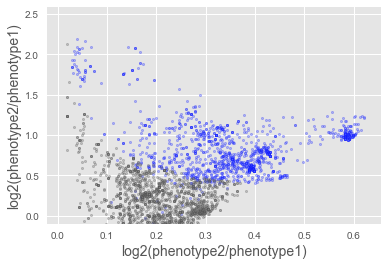

In [1439]:
reload(miner)
genes_to_highlight = [ikzf1]
volcano_data_all = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = None,minRegulons = 2,useAllRegulons = True,highlight = genes_to_highlight,savefile = os.path.join(resultsDirectory,"baseline_vs_relapse_all_regulons.pdf"))

completed in 2.63 minutes


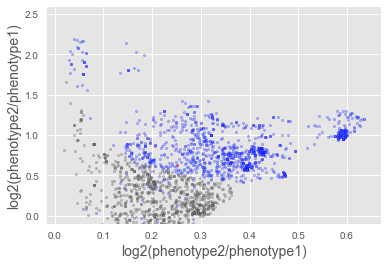

In [1440]:
reload(miner)
targets = [ikzf1,ikzf3,crbn,nr3c1,psmb1,psmb5]
volcano_data_3 = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 3,minRegulons = 3,useAllRegulons = False,highlight = targets,savefile = os.path.join(resultsDirectory,"baseline_vs_relapse_top3regulons.pdf"))

completed in 2.03 minutes
Error: Analysis was successful, but could not generate plot


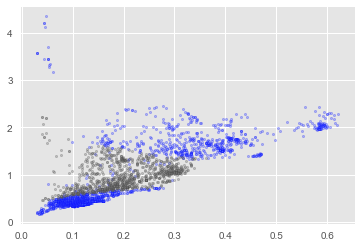

In [1385]:
reload(miner)
targets = [ikzf1]
volcano_data_5 = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 5,minRegulons = 5,useAllRegulons = False,highlight = targets,savefile = os.path.join(resultsDirectory,"baseline_vs_relapse_top5regulons.pdf"))

Text(0.5,0,u'Overexpression frequency at relapse')

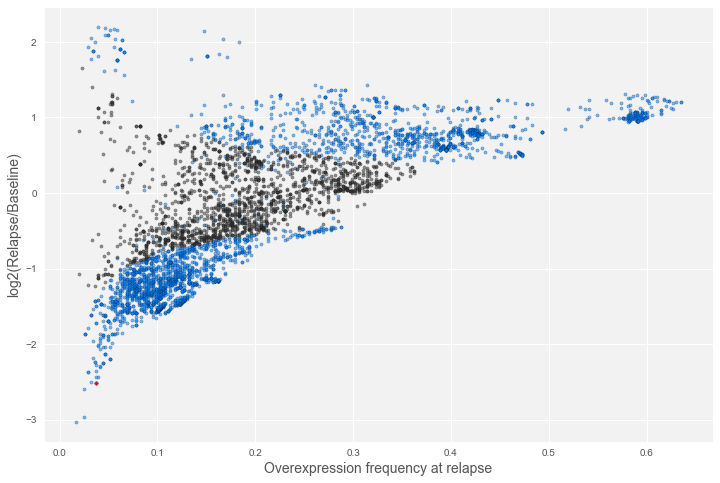

In [1815]:
#Visualize differential network activity

volcano_data_ = volcano_data_3.copy()

insigvoldata_patients = volcano_data_.index[volcano_data_["-log10(p)"]<=-np.log10(0.05)]
sigvoldata_patients = volcano_data_.index[volcano_data_["-log10(p)"]>-np.log10(0.05)]

insigvoldata = volcano_data_.loc[insigvoldata_patients,:]
sigvoldata = volcano_data_.loc[sigvoldata_patients,:]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor([0.95,0.95,0.95])
#ax.grid(color=[0.9,0.9,0.9])
ax.scatter(sigvoldata["phenotype2_frequency"],np.array(sigvoldata["log2(phenotype2/phenotype1)"]),color = [0,0.5,1],edgecolor = [0,0.2,0.4],alpha=0.5,s=10)
ax.scatter(insigvoldata["phenotype2_frequency"],np.array(insigvoldata["log2(phenotype2/phenotype1)"]),color = [0.2,0.2,0.2],edgecolor = [0.1,0.1,0.1],alpha=0.5,s=10)
ax.scatter(volcano_data_.loc[ikzf1,"phenotype2_frequency"],np.array(volcano_data_.loc[ikzf1,"log2(phenotype2/phenotype1)"]),color = [0.9,0.0,0.0],edgecolor=[0.8,0.4,0.4],s=10)
#ax.scatter(volcano_data_.loc[phf19,"phenotype2_frequency"],np.array(volcano_data_.loc[phf19,"log2(phenotype2/phenotype1)"]),color = "red",edgecolor="blue",s=5)

#plt.ylim(-2.8,2.4)
plt.ylabel("log2(Relapse/Baseline)",FontSize=14)
plt.xlabel("Overexpression frequency at relapse",FontSize=14)
#plt.savefig(os.path.join(resultsDirectory,"differential_network_volcano.pdf"),bbox_inches="tight")

In [1446]:
# Output genes from differential network activity analysis
volcano_df = volcano_data_3.copy()
volcano_df.sort_values(by="phenotype2_frequency",ascending=False,inplace=True)
miner.gene_conversion(volcano_df.index[0:50],list_symbols=True)

querying 1-50...done.
Finished.


[u'PAQR4',
 u'CACYBP',
 u'SMC1A',
 u'TK1',
 u'CDC20',
 u'NUF2',
 u'PCNA',
 u'DTL',
 u'FAM72A',
 u'MCM2',
 u'UBE2T',
 u'AURKA',
 u'PLK1',
 u'KIF4A',
 u'CDCA8',
 u'TPX2',
 u'MCM6',
 u'CDK1',
 u'PHF19',
 u'TSEN15',
 u'CBX5',
 u'TOPBP1',
 u'UBE2C',
 u'GINS1',
 u'E2F2',
 u'TUBA1B',
 u'NEK2',
 u'POLE2',
 u'MCM7',
 u'HDGF',
 u'POLA2',
 u'TOMM40L',
 u'DHFR',
 u'MAD2L1',
 u'WDR76',
 u'UNG',
 u'DLGAP5',
 u'CLSPN',
 u'ARPC5',
 u'AURKB',
 u'BRCA1',
 u'MCM4',
 u'SMG5',
 u'ATAD2',
 u'FOXM1',
 u'BRI3BP',
 u'ARHGEF39',
 u'KIF14',
 u'ZWINT',
 u'RAD51']

(0, 0.5011650836259061, 1.730750442061483)
(1, 0.5472699549481759, 1.030568074663847)
(2, 0.40525771523219667, -0.6889856750465883)
(3, 0.5765089857633043, 0.2052145126348778)
(4, 0.4782838633027568, -0.2601354743677727)
[0]	validation_0-auc:0.809113	validation_1-auc:0.526531
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.870514	validation_1-auc:0.452041
[2]	validation_0-auc:0.903765	validation_1-auc:0.506122
classified 11.0 percent of training population as high-risk
classified 11.6 percent of test population as high-risk
3


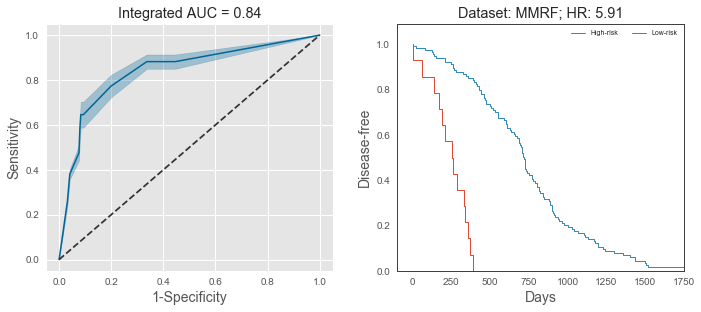

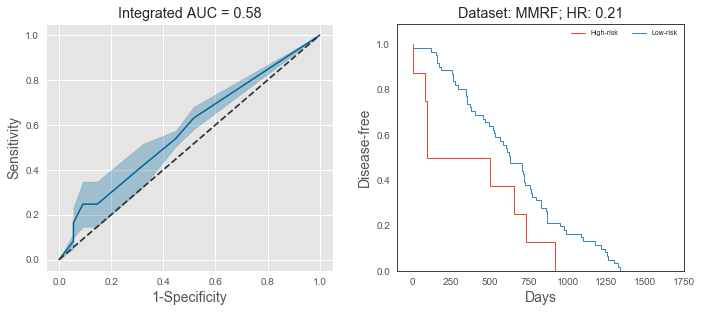

In [1557]:
reload(miner)
nextIteration_datasets = []
nextIteration_survival = []

class0 = []
class1 = []
for p in range(len(membership_datasets)):
    tmp_class_0 = class_0[p]
    nextIteration_datasets.append(membership_datasets[p].loc[:,tmp_class_0])
    tmp_srv = survival_datasets[p][survival_datasets[p].iloc[:,1]==1]
    nextIteration_survival.append(survival_datasets[p].loc[list(set(tmp_class_0)&set(tmp_srv.index)),:])
    
nextIteration_classifier, nextIteration_class_0, nextIteration_class_1 = miner.generatePredictor(nextIteration_datasets,nextIteration_survival,dataset_labels,iterations = 5,method='xgboost',output_directory=resultsDirectory,metric='roc_auc',separate_results=True,n_estimators=3,class1_proportion=0.25)